# XGBoost Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
from scipy.stats import pearsonr
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
problem_types = ['regression','classification'] #regression or classification
input_types = ["genetic_algorithm","random_forest_elimination","correlation_variance_filter","PCA","Factor_Analysis"] #reduced features: , genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254

In [3]:
def read_file(problem_type, input_file):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.

    Returns:
        tuple:
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    # Validate problem type
    if problem_type not in {'regression', 'classification'}:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    # Define the target column based on problem type
    target_column = '-logIC50' if problem_type == 'regression' else 'Potency'

    # Load input features and target data
    X = pd.read_csv(input_file)
    target = pd.read_csv('../../3_train_test_split/descriptors_all.csv', usecols=['Molecule ChEMBL ID', target_column])

    # Merge target data with features based on 'Molecule ChEMBL ID'
    target = target[target['Molecule ChEMBL ID'].isin(X['Molecule ChEMBL ID'])]

    # Return original and indexed feature DataFrame, and target values as a Series
    return X.set_index('Molecule ChEMBL ID'), target.set_index('Molecule ChEMBL ID')[target_column]

In [4]:
def run_xgboost(problem_type, input_type, seed=42):
    """
    Run XGBoost for regression or classification with 5-fold cross-validation and hyperparameter optimization.

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Directory of input feature reduction scheme (e.g., 'PCA', 'Factor_Analysis').
        seed (int): Random seed for reproducibility.

    Returns:
        dict: Best model, test predictions, evaluation metrics, and test dataset.
    """
    base_dir = f"../../4_feature_selection/{input_type}/"
    if input_type == "PCA":
        base_dir = os.path.join(base_dir, "PCA_results/PCA_components/")
    elif input_type == "Factor_Analysis":
        base_dir = os.path.join(base_dir, "FA_results/selected_features/")
    elif input_type == "genetic_algorithm":
        base_dir = os.path.join(base_dir, "xgboost/")

    problem = "reg" if problem_type == "regression" else "class"
    train_files = sorted([f for f in os.listdir(base_dir) if f.startswith(f"train_{problem}")])
    val_files = sorted([f for f in os.listdir(base_dir) if f.startswith(f"val_{problem}")])
    test_file = os.path.join(base_dir, f"test_{problem}.csv")

    # Load test dataset
    X_test, y_test = read_file(problem_type, test_file)
    test_chembl_ids = list(y_test.index)

    # Label encoding for classification
    label_encoder = None
    if problem_type == "classification":
        label_encoder = LabelEncoder()
        y_test = label_encoder.fit_transform(y_test)

    # Initialize hyperparameter distribution for RandomizedSearchCV
    param_distributions = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Initialize model
    if problem_type == "regression":
        model = XGBRegressor(random_state=seed, objective="reg:squarederror")
        scoring = 'neg_mean_squared_error'
    elif problem_type == "classification":
        model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric="logloss")
        scoring = 'accuracy'

    # Perform 5-fold cross-validation
    print(f"Running 5-fold cross-validation for {problem_type}...")
    fold_metrics = []
    best_models = []

    for fold in range(1, 6):
        # Load train and validation files for the current fold
        train_file = os.path.join(base_dir, f"train_{problem}_{fold}.csv")
        val_file = os.path.join(base_dir, f"val_{problem}_{fold}.csv")

        # Load training and validation data
        X_train, y_train = read_file(problem_type, train_file)
        X_val, y_val = read_file(problem_type, val_file)

        # Encode labels for classification
        if problem_type == "classification":
            y_train = label_encoder.transform(y_train)
            y_val = label_encoder.transform(y_val)

        # Hyperparameter optimization using RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)

        # Evaluate the best model on validation data
        best_model = random_search.best_estimator_
        best_models.append(best_model)

        y_val_pred = best_model.predict(X_val)
        if problem_type == "regression":
            metric = mean_squared_error(y_val, y_val_pred)
        else:
            metric = accuracy_score(y_val, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    # Average metric across folds
    avg_metric = np.mean(fold_metrics)
    print(f"Average Cross-Validation Metric: {avg_metric:.4f}")

    # Evaluate the best model on the test set
    if problem_type == "regression":
        final_model = best_models[np.argmin(fold_metrics)]  # Best model with lowest MSE
        test_metric = mean_squared_error(y_test, final_model.predict(X_test))
        print(f"Test MSE: {test_metric:.4f}")
    else:
        final_model = best_models[np.argmax(fold_metrics)]  # Best model with highest accuracy
        test_metric = accuracy_score(y_test, final_model.predict(X_test))
        print(f"Test Accuracy: {test_metric:.4f}")

    # Save evaluation metrics, predictions, and plots
    evaluate_model(final_model,X_test,y_test,problem_type,input_type,"XGBoost")

    return {
        'best_model': final_model,
        'test_predictions': final_model.predict(X_test),
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test
    }

In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type):
    """
    Evaluate the model, create plots, and save performance summary and predictions.

    Parameters:
        final_model: Trained model.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): True target values for the test set.
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme used.
        model_type (str): Model type (default is 'random forest').

    Returns:
        None
    """
    # Generate file prefix
    file_prefix = f"{model_type}_{problem_type}_{input_type}"

    # Predictions
    y_pred = final_model.predict(X_test)

    if problem_type == "regression":
        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        pearson_corr, _ = pearsonr(y_test, y_pred)

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "mse": mse,
            "r2_score": r2,
            "pearson_corr": pearson_corr
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Predicted vs Target
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs True")
        plt.savefig(f"{file_prefix}_predicted_vs_true.png")
        plt.show()

        # Plot Residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=residuals, alpha=0.7)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Residuals")
        plt.title("Residual Plot")
        plt.savefig(f"{file_prefix}_residuals.png")
        plt.show()

    elif problem_type == "classification":
        # Calculate classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": y_test,
            "Predicted Potency": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()

        # Plot ROC Curve
        if hasattr(final_model, "predict_proba"):
            y_proba = final_model.predict_proba(X_test)
            plt.figure(figsize=(8, 6), dpi=150)
            for i, class_label in enumerate(final_model.classes_):
                fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="red", linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (One-vs-Rest)")
            plt.legend()
            plt.savefig(f"{file_prefix}_roc_curve.png")
            plt.show()

Training XGBoost for regression using genetic_algorithm features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 3.1419
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 2 - Best Model Metric: 3.0309
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 3 - Best Model Metric: 4.4758
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 4 - Best Model Metric: 5.0633
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 5 - Best Model Metric: 2.5777
Average Cross-Validation Metric: 3.6579
Test MSE: 3.9164


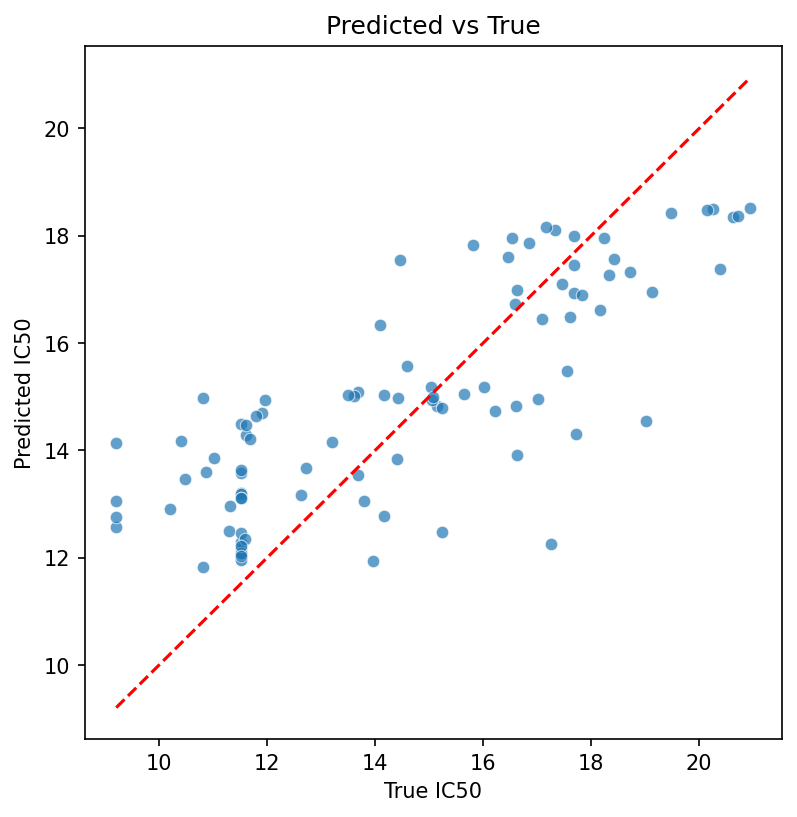

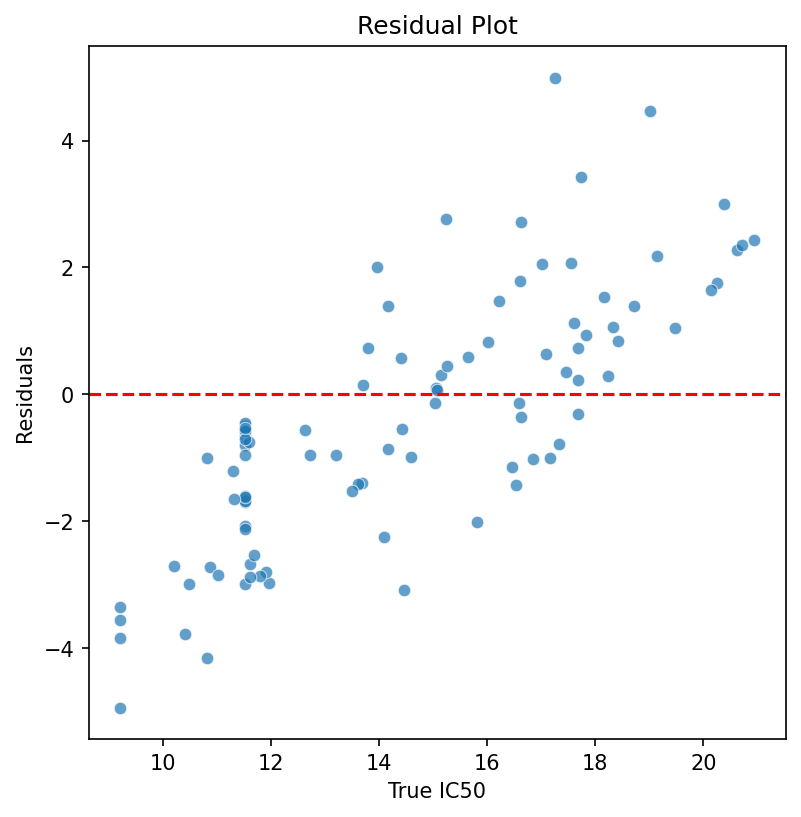

Evaluating the model...


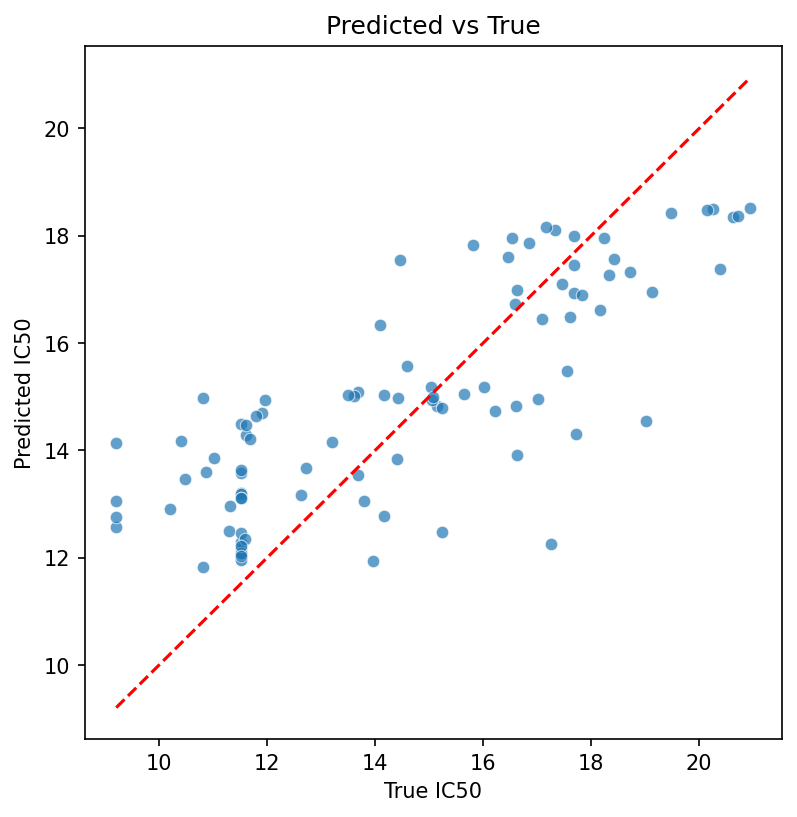

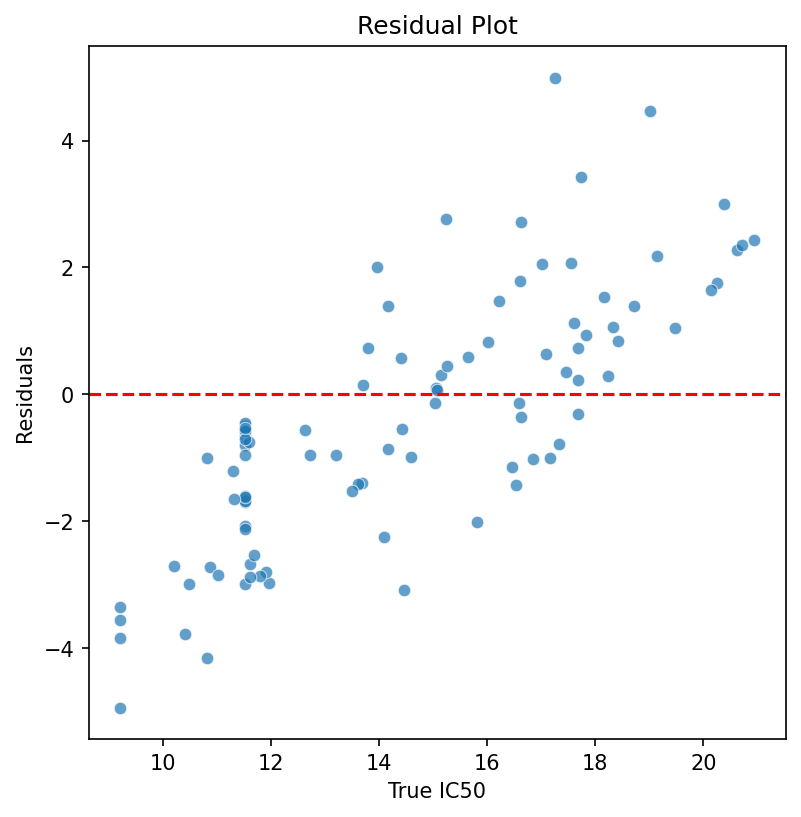

Training and evaluation complete
Training XGBoost for regression using random_forest_elimination features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 1 - Best Model Metric: 8.9822
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 2 - Best Model Metric: 8.4570
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 3 - Best Model Metric: 9.1573
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 11.5687
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 5 - Best Model Metric: 8.2565
Average Cross-Validation Metric: 9.2843
Test MSE: 10.0867


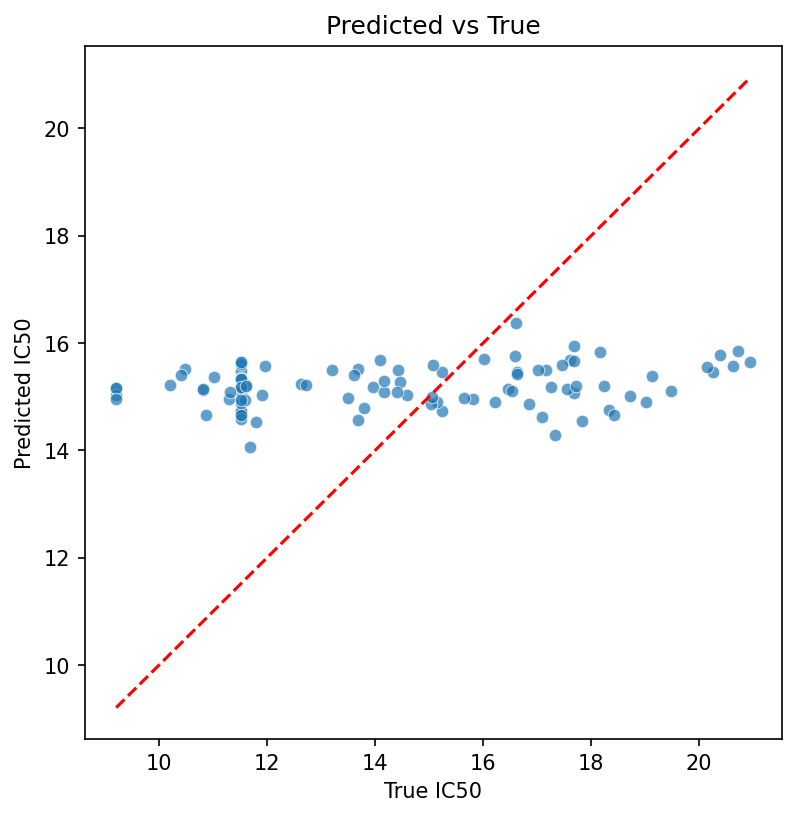

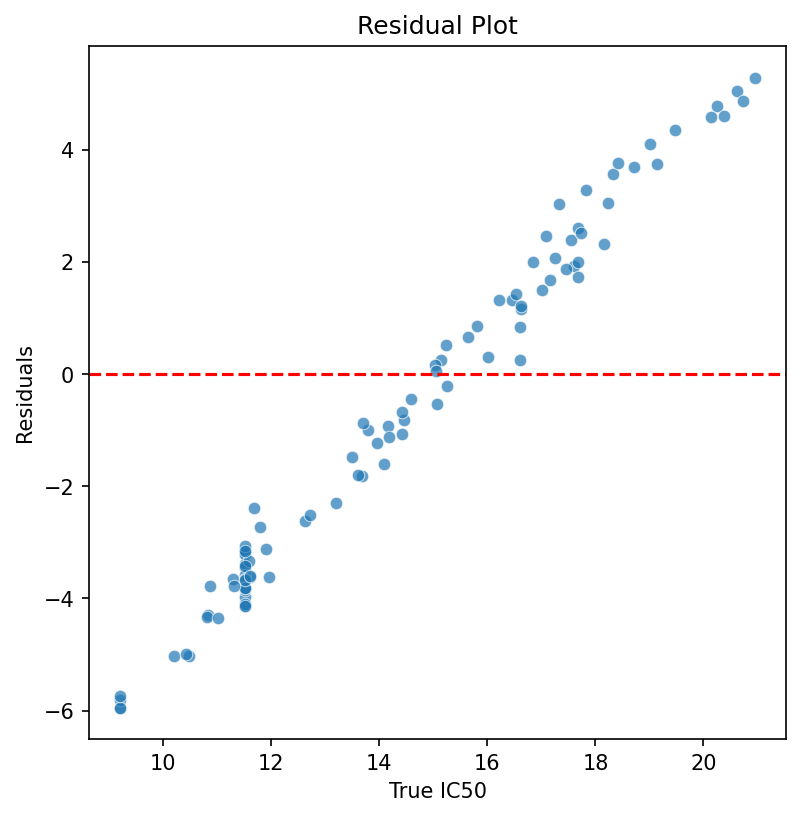

Evaluating the model...


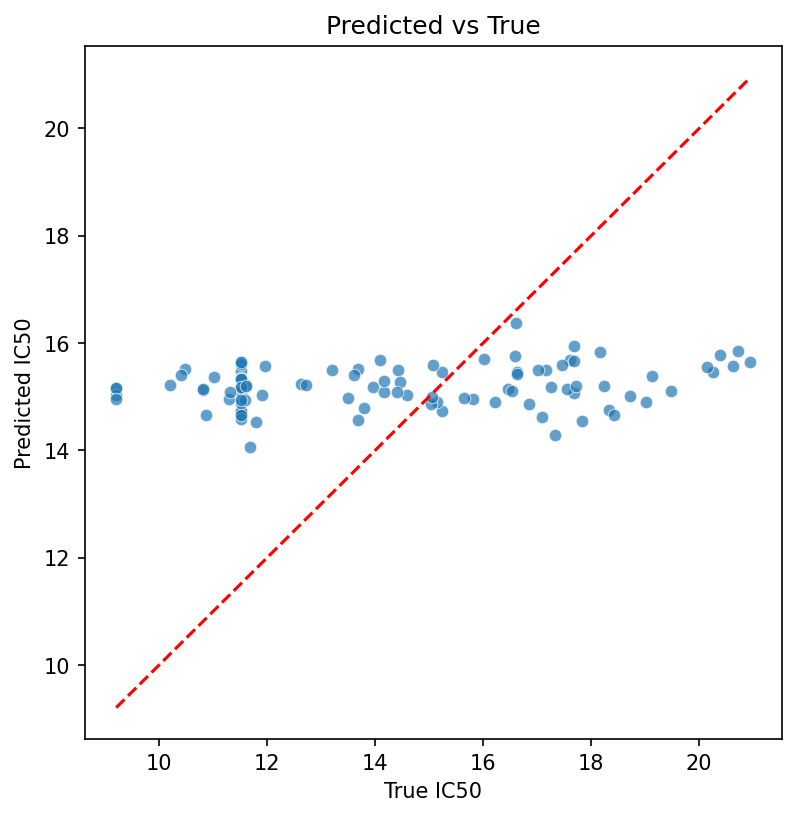

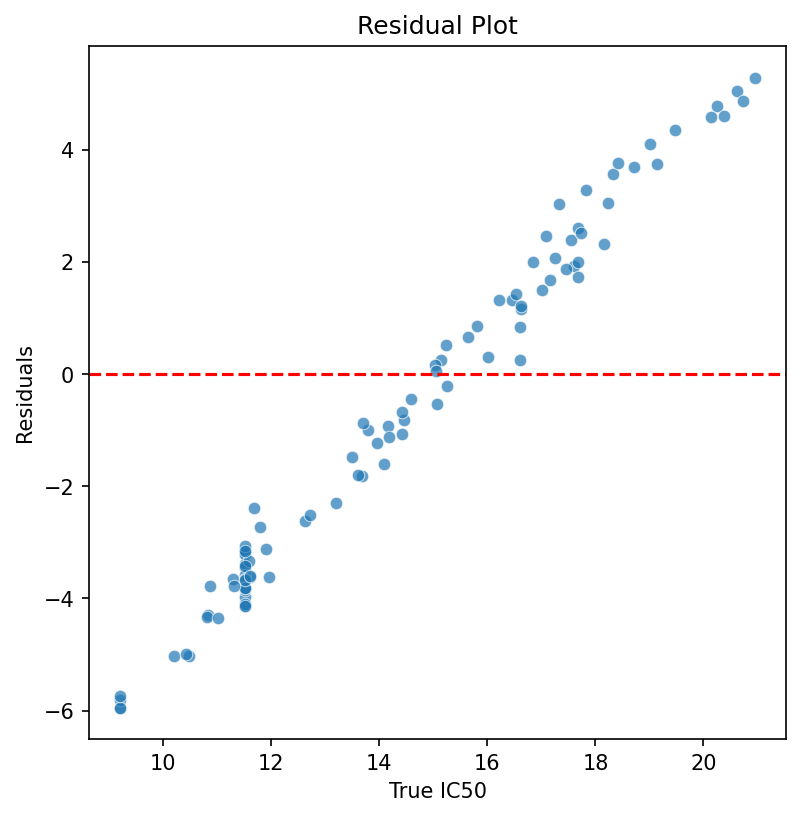

Training and evaluation complete
Training XGBoost for regression using correlation_variance_filter features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 1 - Best Model Metric: 3.0043
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 2 - Best Model Metric: 3.3396
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 3 - Best Model Metric: 4.8076
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 4 - Best Model Metric: 5.4644
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 5 - Best Model Metric: 2.7799
Average Cross-Validation Metric: 3.8792
Test MSE: 3.8794


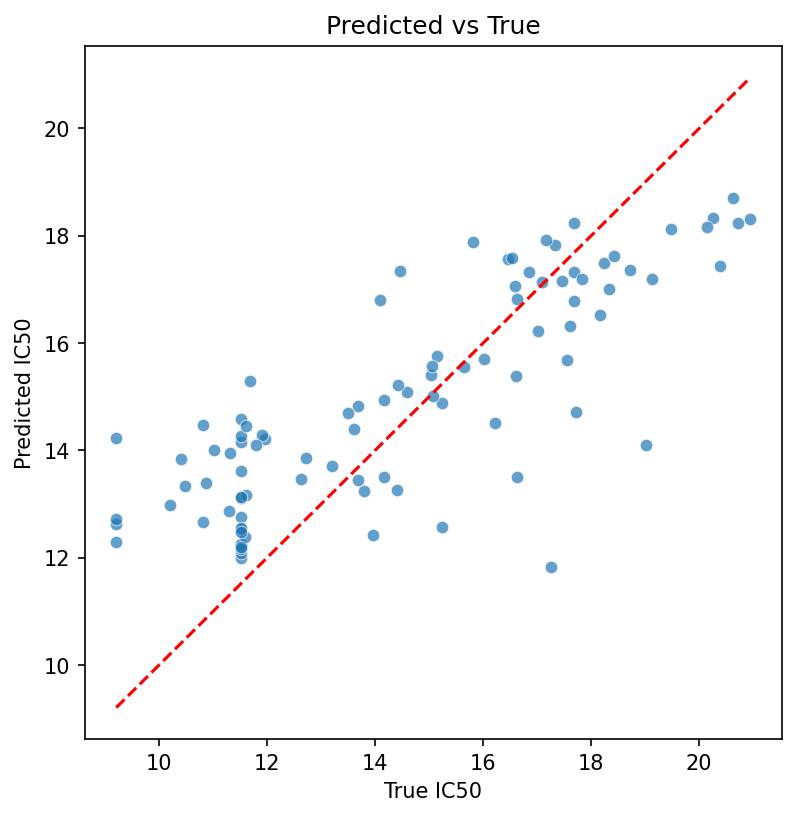

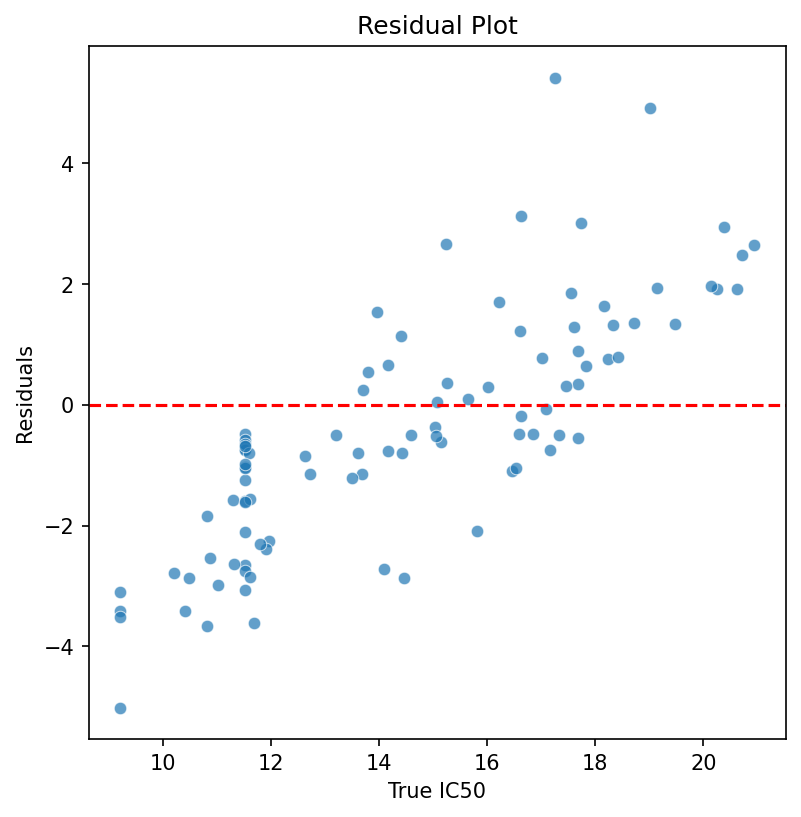

Evaluating the model...


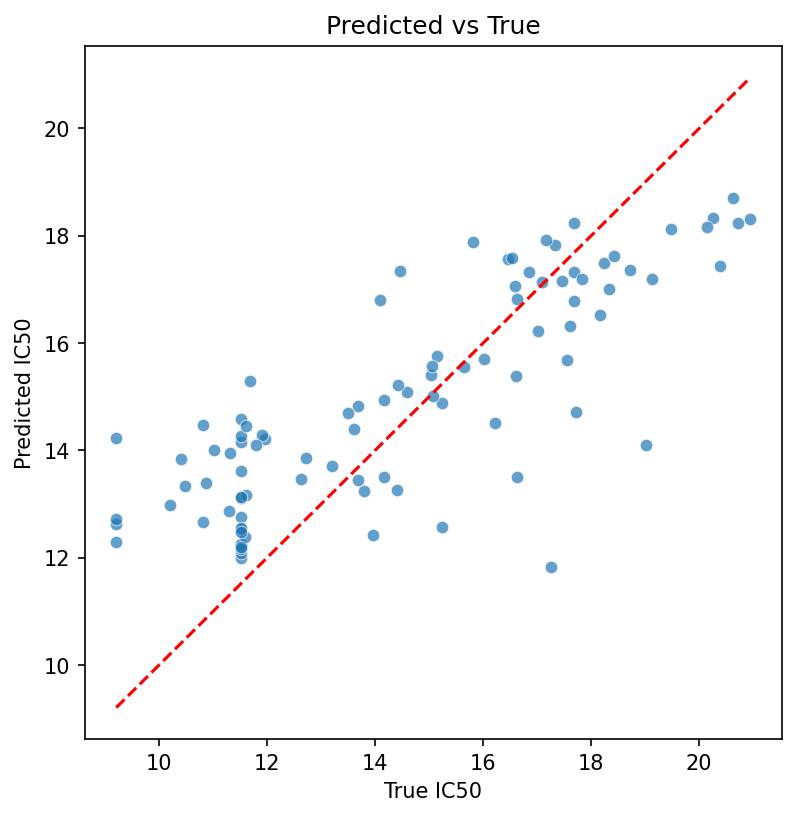

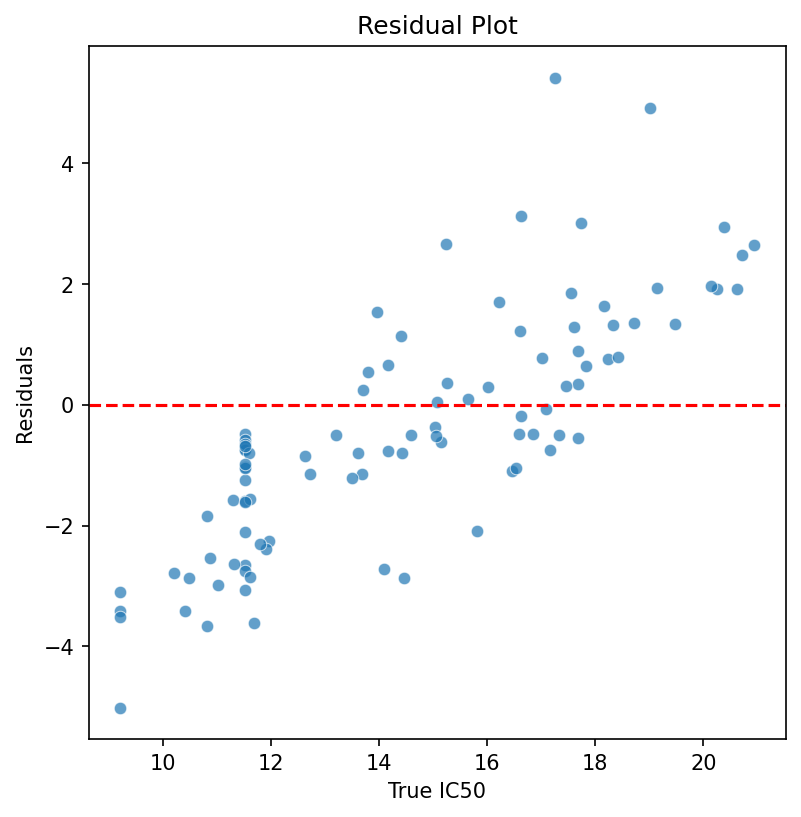

Training and evaluation complete
Training XGBoost for regression using PCA features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 9.2722
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 2 - Best Model Metric: 8.8863
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 3 - Best Model Metric: 9.1258
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 11.5547
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 5 - Best Model Metric: 8.5400
Average Cross-Validation Metric: 9.4758
Test MSE: 10.4463


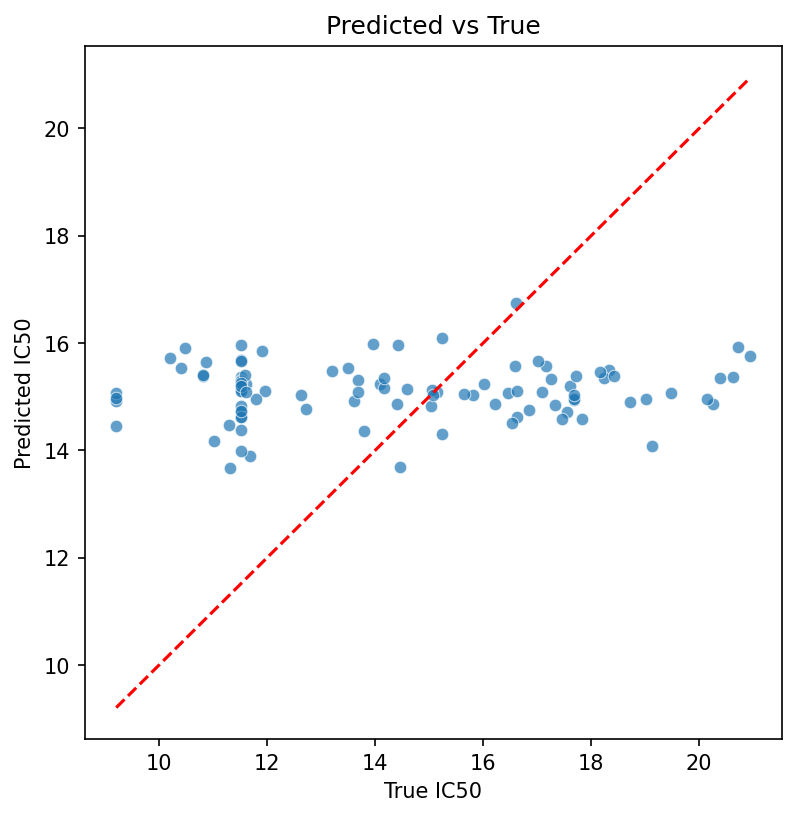

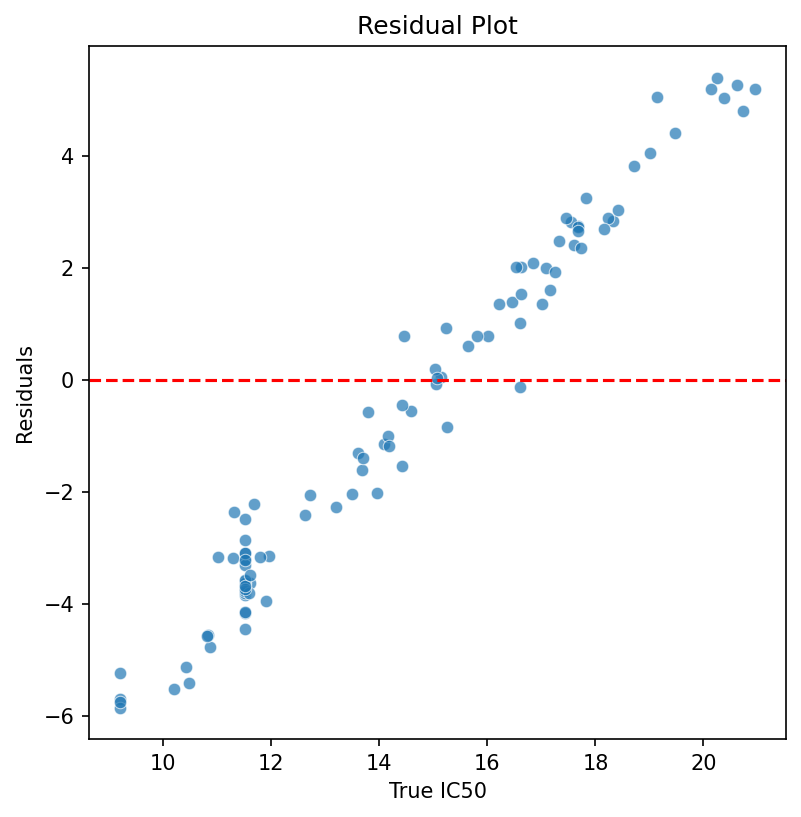

Evaluating the model...


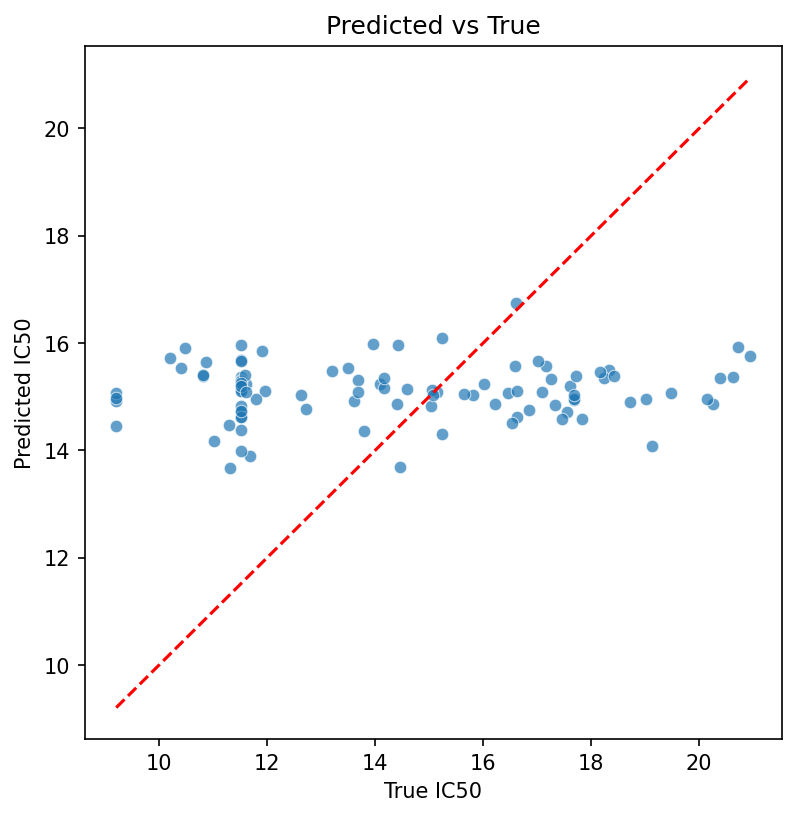

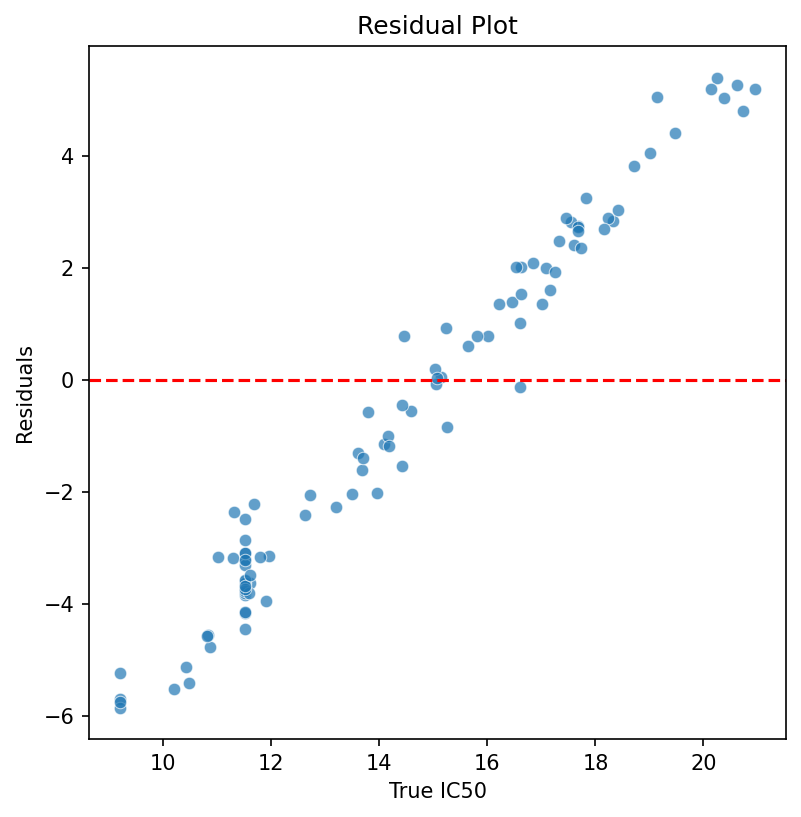

Training and evaluation complete
Training XGBoost for regression using Factor_Analysis features...
Running 5-fold cross-validation for regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 9.6055
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 2 - Best Model Metric: 8.5268
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 3 - Best Model Metric: 9.4205
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 11.2206
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 5 - Best Model Metric: 8.1797
Average Cross-Validation Metric: 9.3906
Test MSE: 10.2693


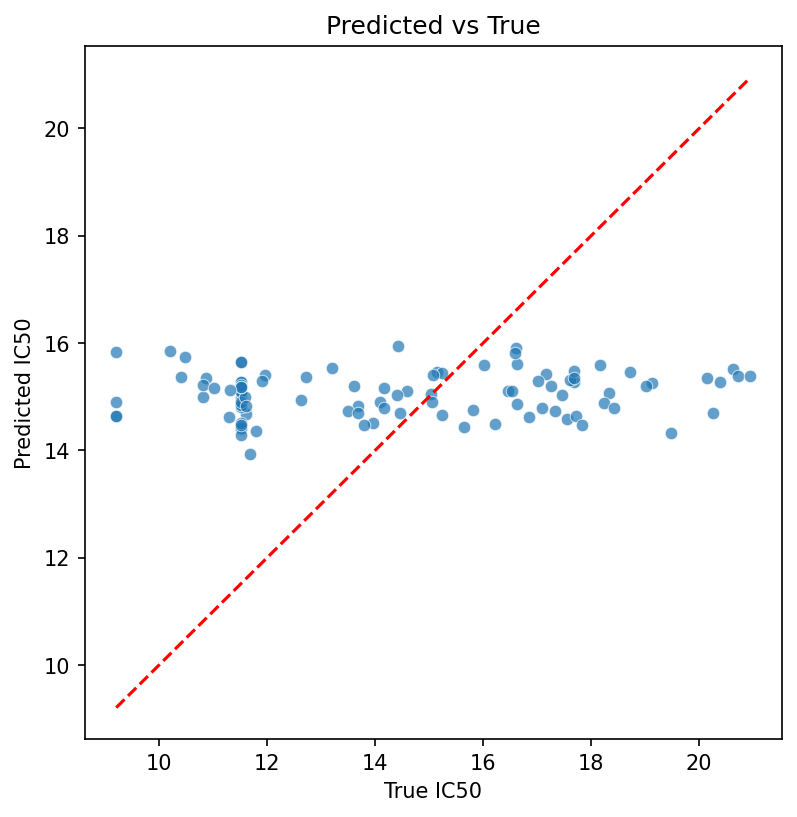

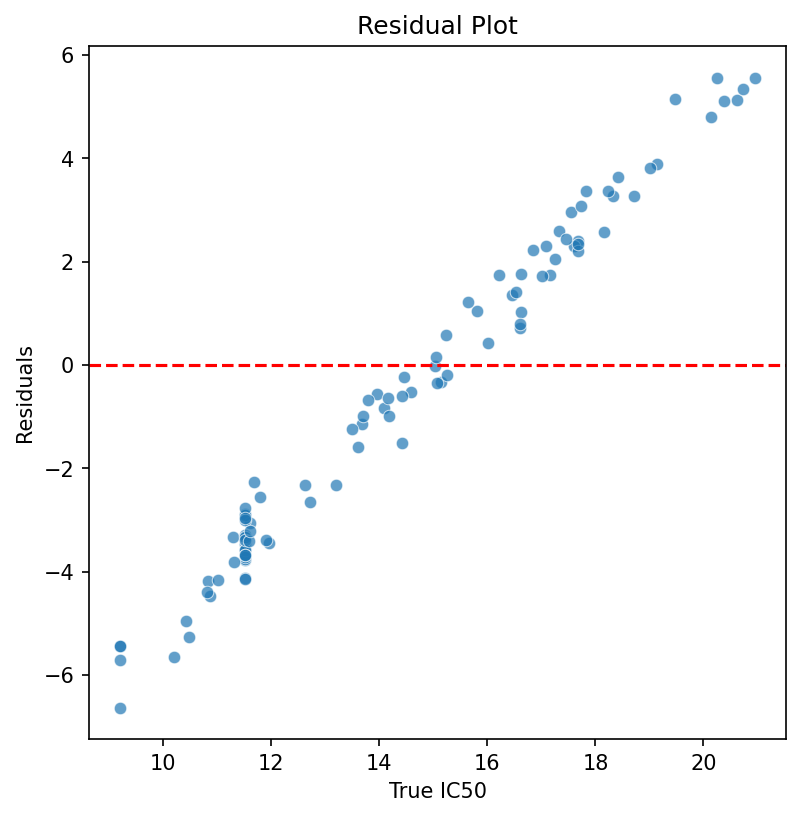

Evaluating the model...


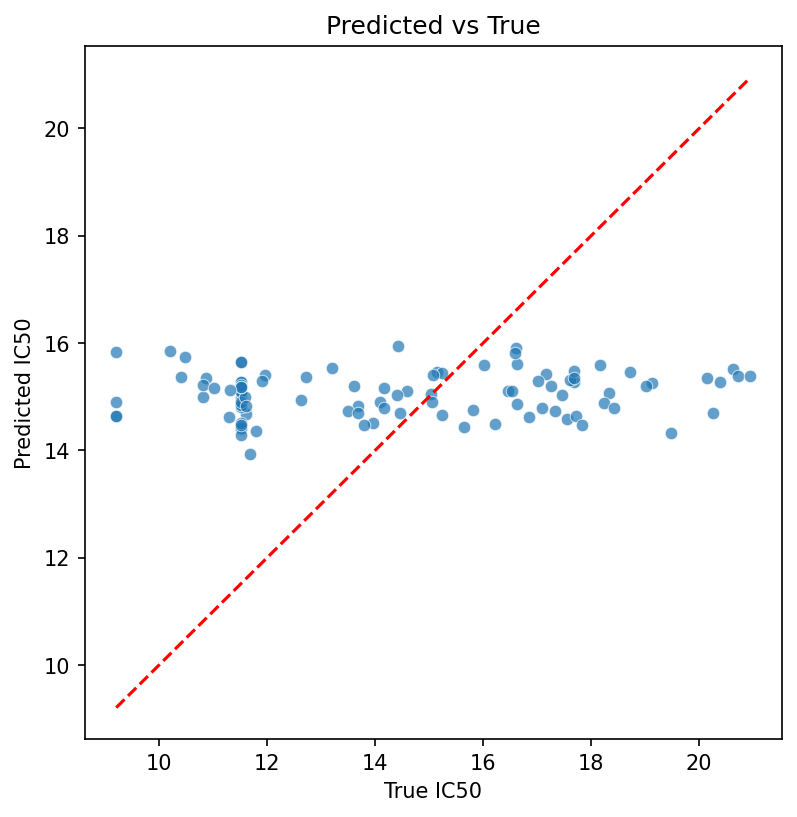

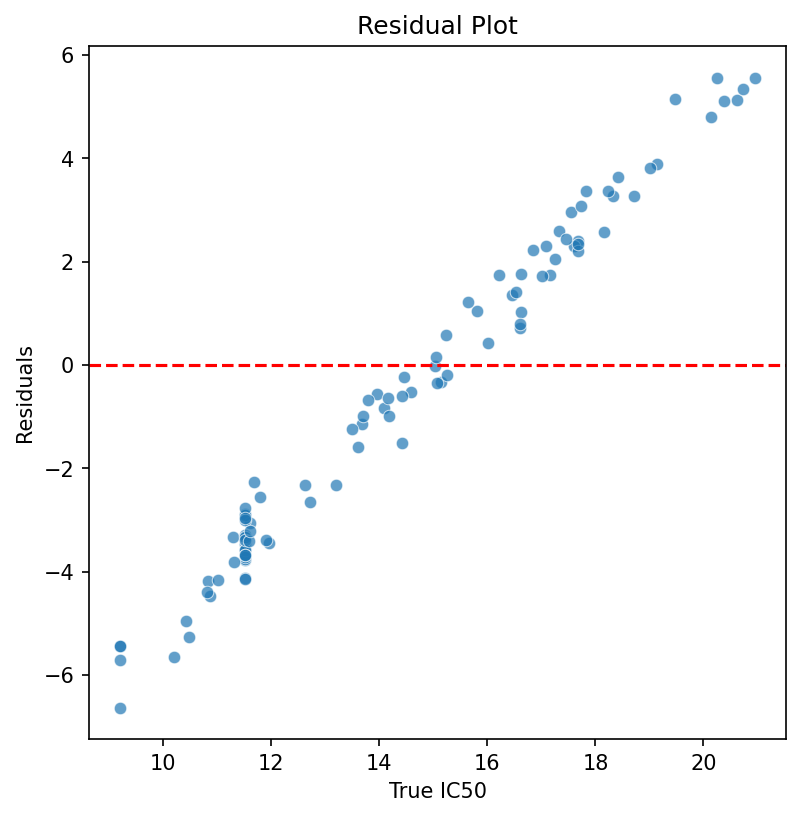

Training and evaluation complete
Training XGBoost for classification using genetic_algorithm features...
Running 5-fold cross-validation for classification...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 1 - Best Model Metric: 0.6216
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 2 - Best Model Metric: 0.6847
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 3 - Best Model Metric: 0.6216
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 4 - Best Model Metric: 0.6036
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:00:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:00:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:00:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 5 - Best Model Metric: 0.6036
Average Cross-Validation Metric: 0.6270
Test Accuracy: 0.6263


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


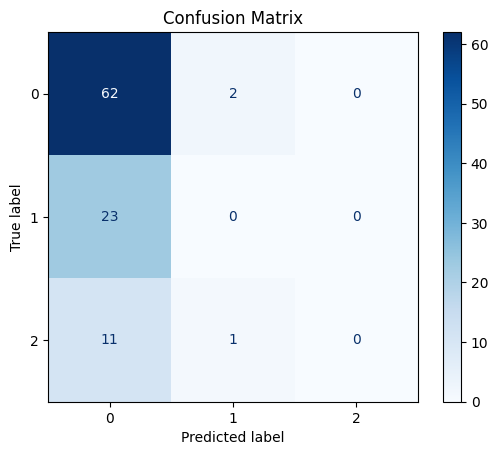

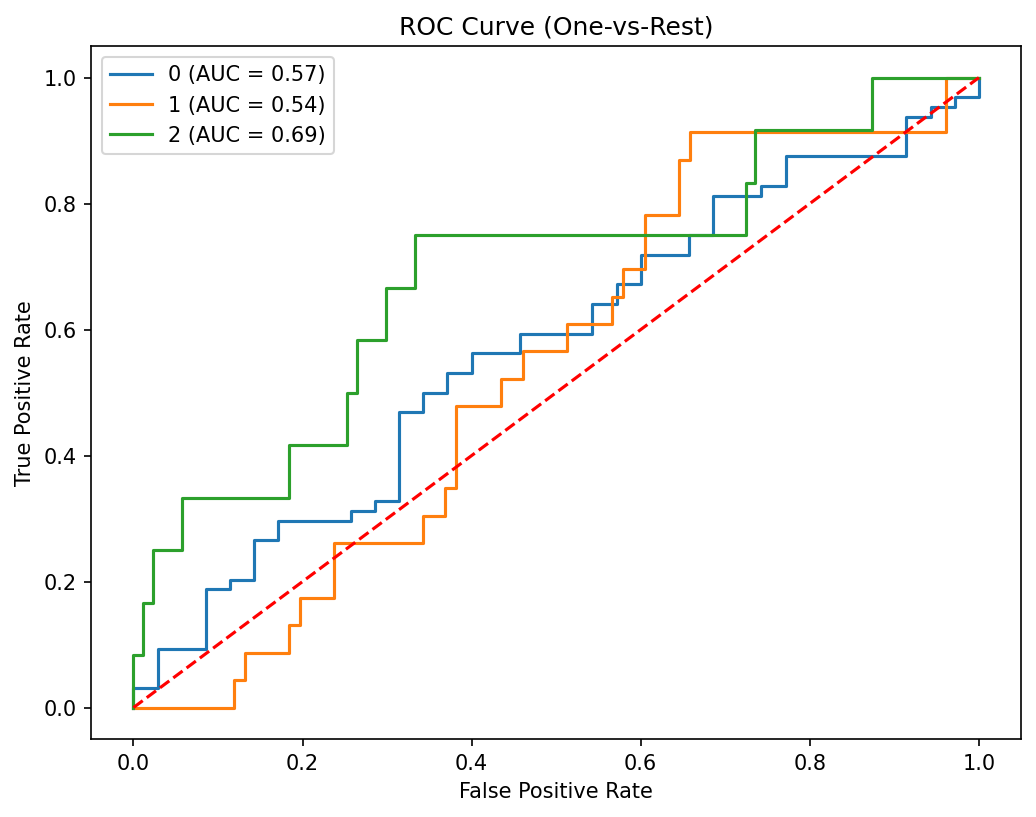

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


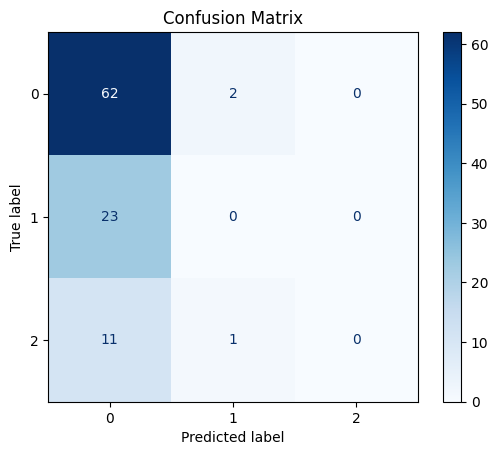

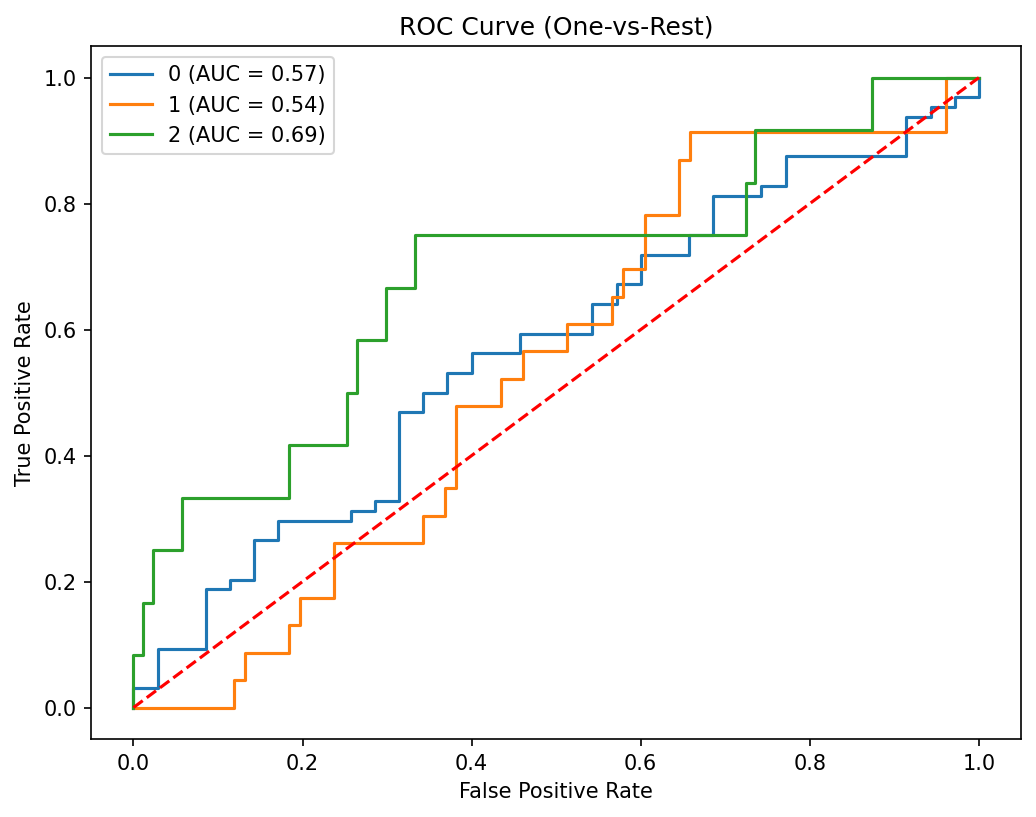

Training and evaluation complete
Training XGBoost for classification using random_forest_elimination features...
Running 5-fold cross-validation for classification...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:03:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:03:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:03:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 1 - Best Model Metric: 0.6486
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:06:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:06:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:06:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 2 - Best Model Metric: 0.6937
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:09:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:09:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:09:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 3 - Best Model Metric: 0.6216
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:12:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:12:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:12:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 4 - Best Model Metric: 0.6036
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:15:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:15:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:15:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 5 - Best Model Metric: 0.6036
Average Cross-Validation Metric: 0.6342
Test Accuracy: 0.5960


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


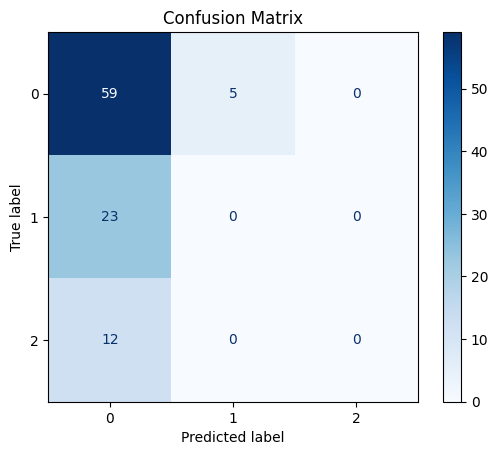

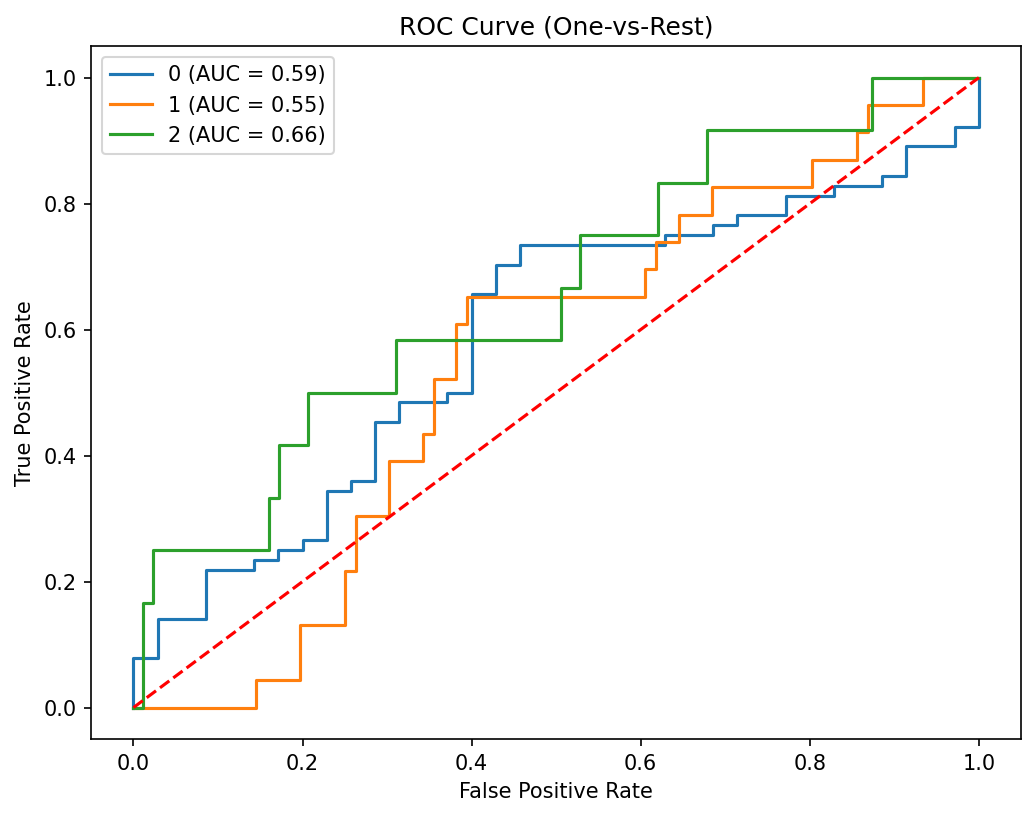

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


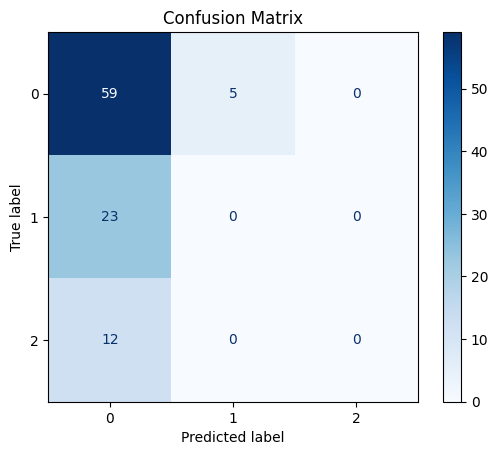

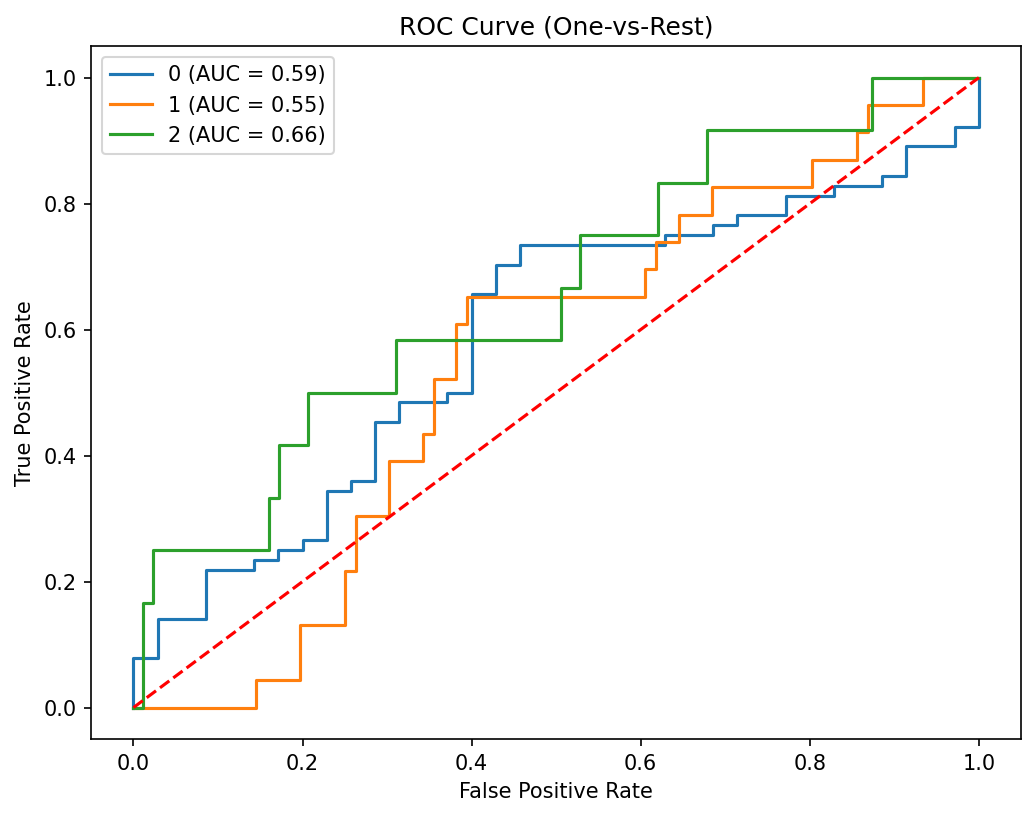

Training and evaluation complete
Training XGBoost for classification using correlation_variance_filter features...
Running 5-fold cross-validation for classification...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:18:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:18:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:18:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 1 - Best Model Metric: 0.6396
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 2 - Best Model Metric: 0.6667
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:23:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:23:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:23:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 3 - Best Model Metric: 0.6036
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:25:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:25:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:25:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 4 - Best Model Metric: 0.6036
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:28:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:28:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:28:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 5 - Best Model Metric: 0.6036
Average Cross-Validation Metric: 0.6234
Test Accuracy: 0.6263


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


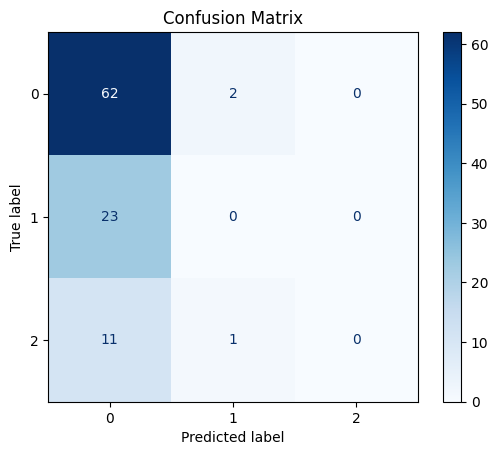

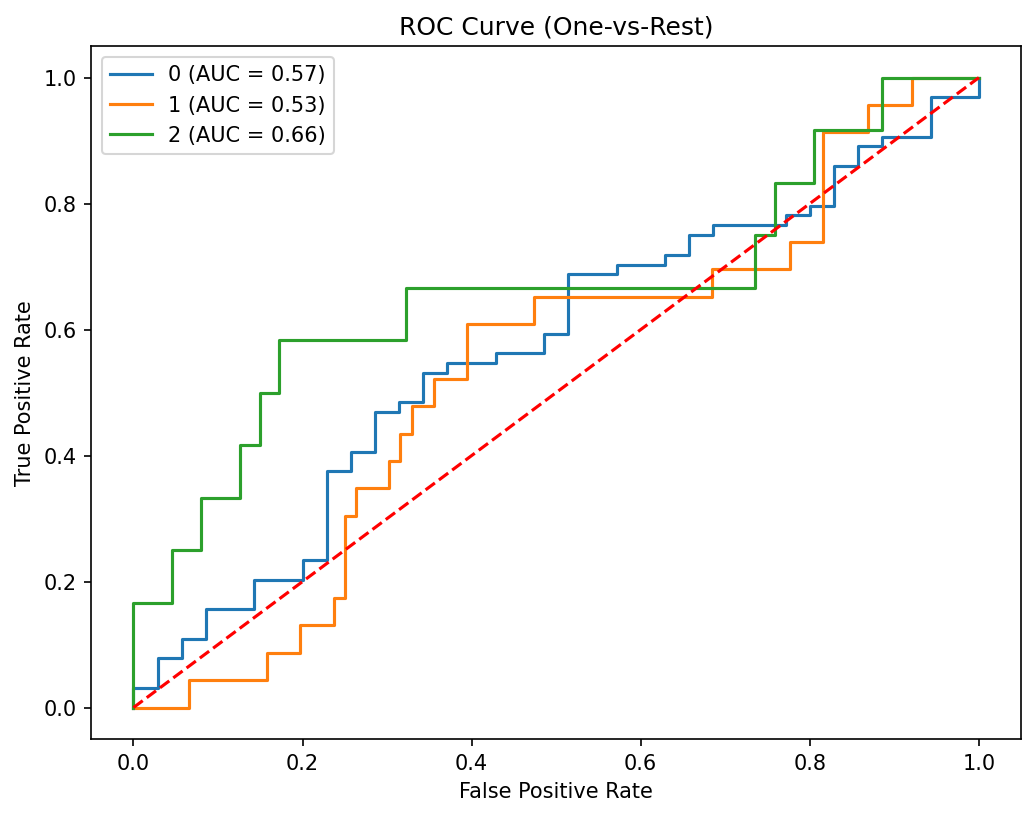

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


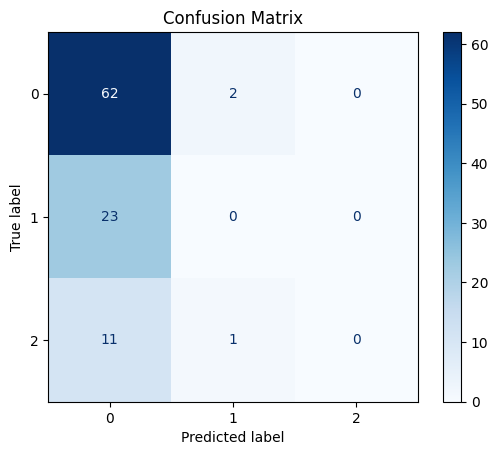

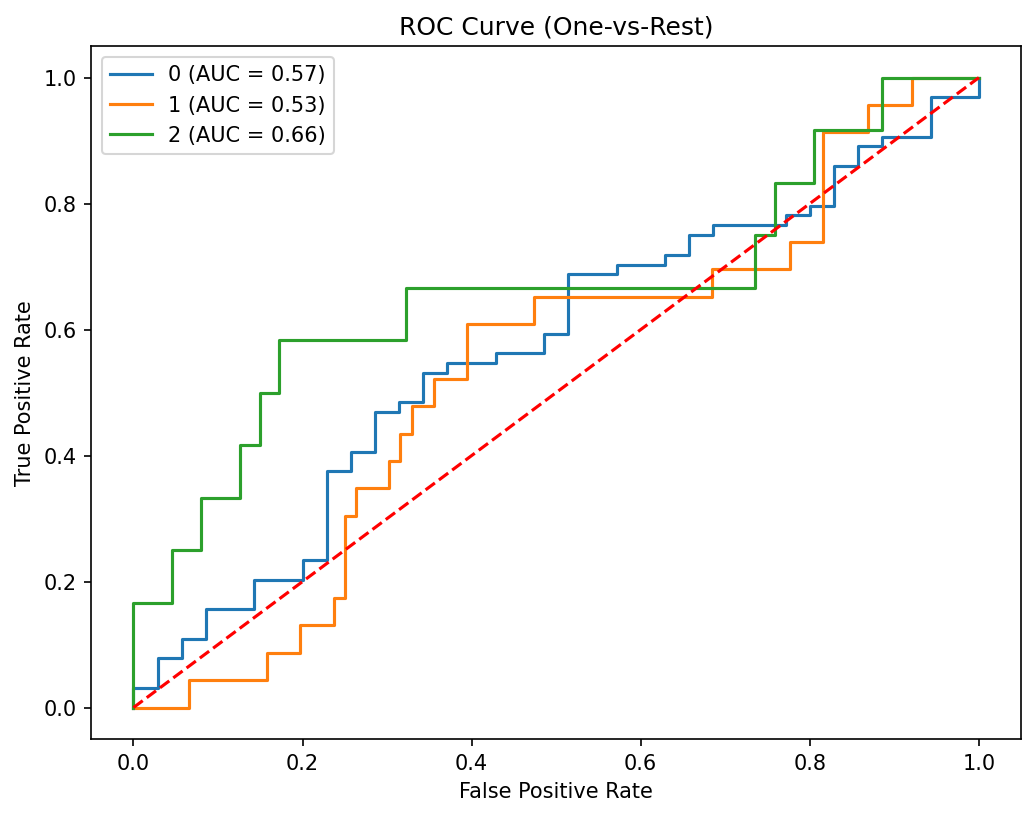

Training and evaluation complete
Training XGBoost for classification using PCA features...
Running 5-fold cross-validation for classification...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 1 - Best Model Metric: 0.6396
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 2 - Best Model Metric: 0.6486
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 3 - Best Model Metric: 0.6126
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 4 - Best Model Metric: 0.5856
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 5 - Best Model Metric: 0.5766
Average Cross-Validation Metric: 0.6126
Test Accuracy: 0.6465


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


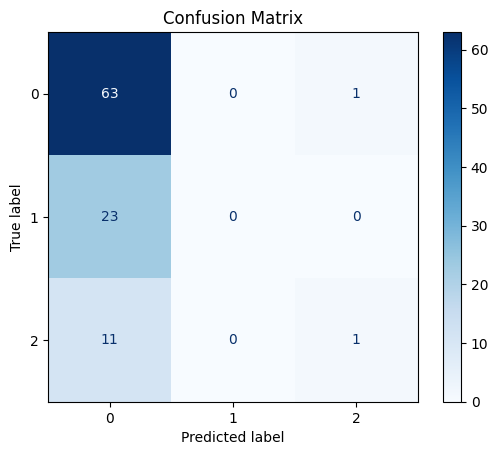

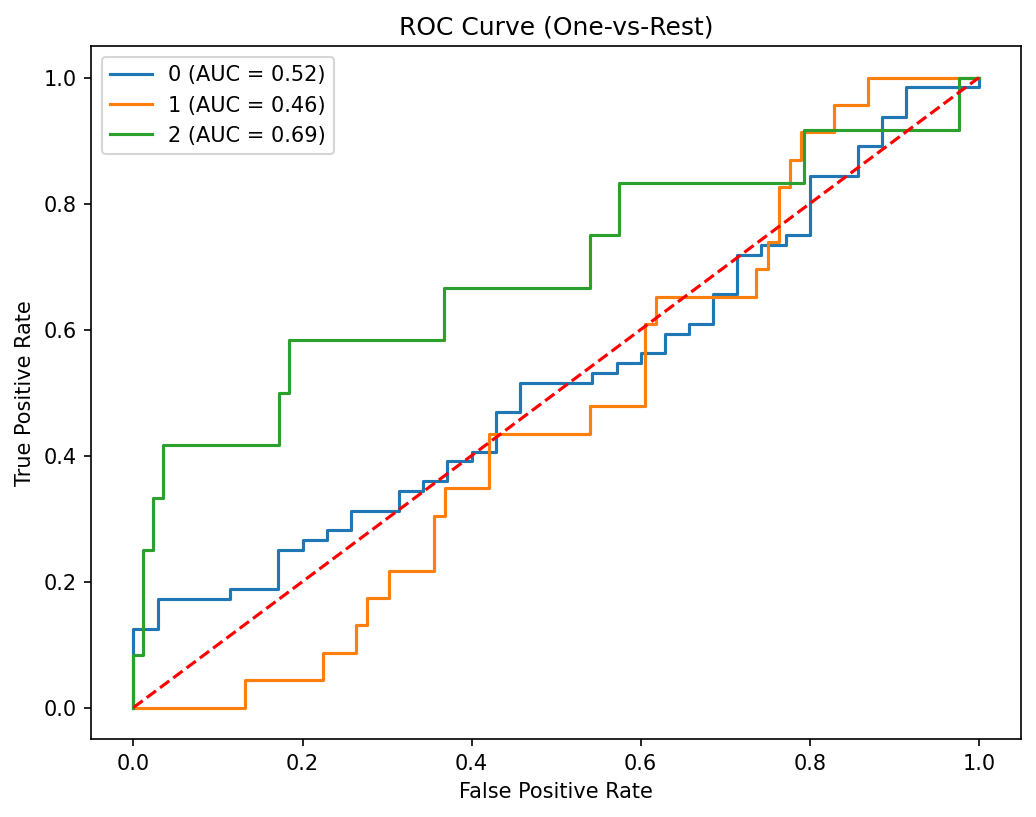

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


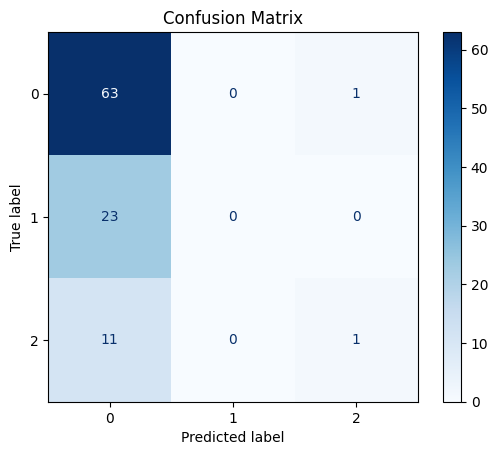

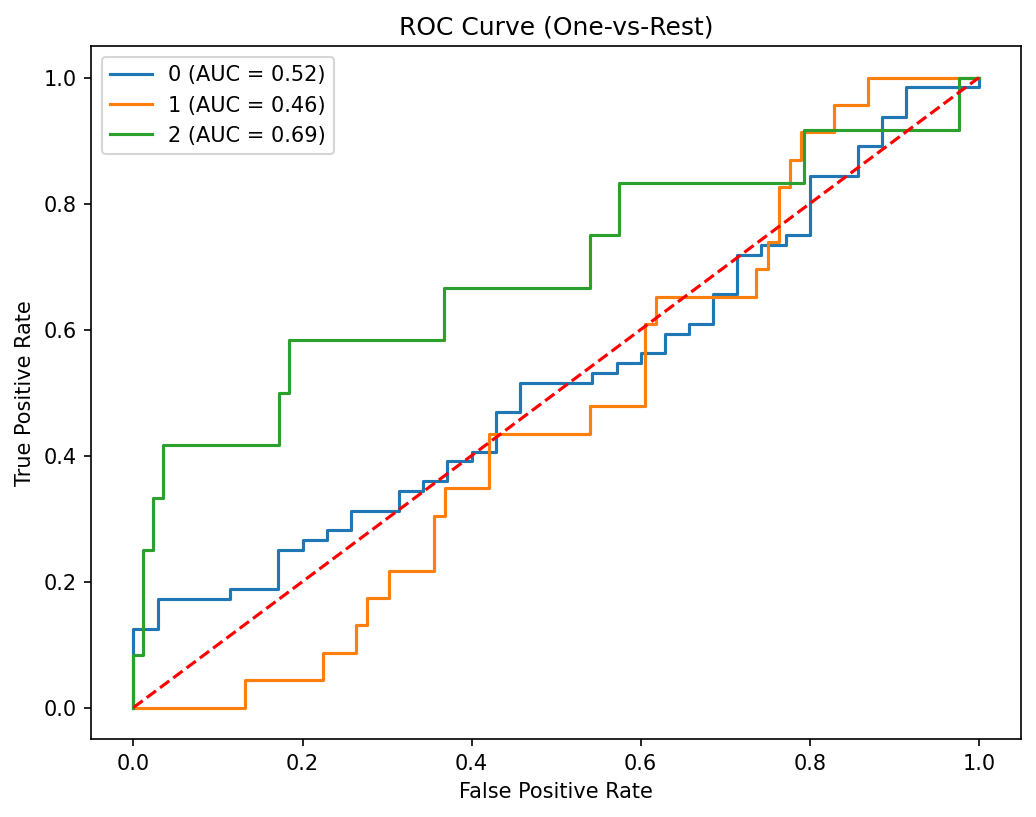

Training and evaluation complete
Training XGBoost for classification using Factor_Analysis features...
Running 5-fold cross-validation for classification...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 1 - Best Model Metric: 0.6306
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:31:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 2 - Best Model Metric: 0.6486
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 3 - Best Model Metric: 0.6126
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 4 - Best Model Metric: 0.5946
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807642624/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/xgboost/core.py:1

Fold 5 - Best Model Metric: 0.6036
Average Cross-Validation Metric: 0.6180
Test Accuracy: 0.6263


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


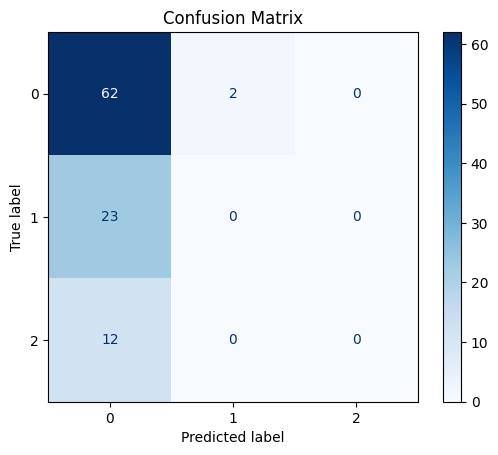

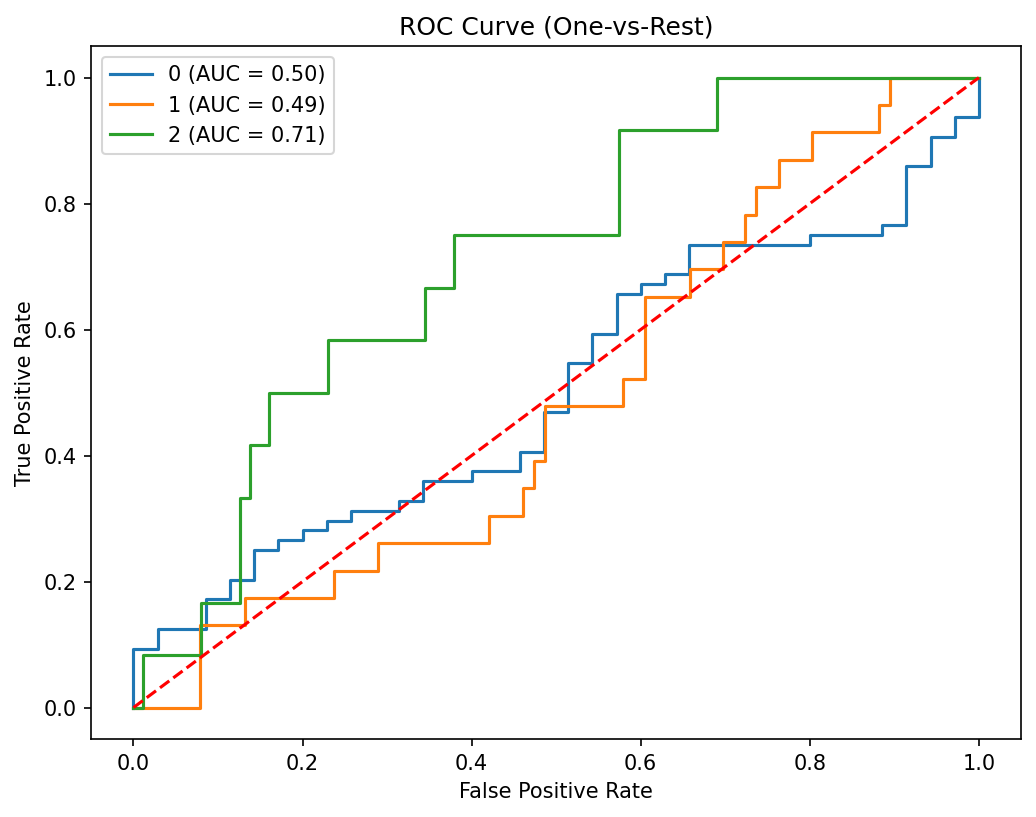

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


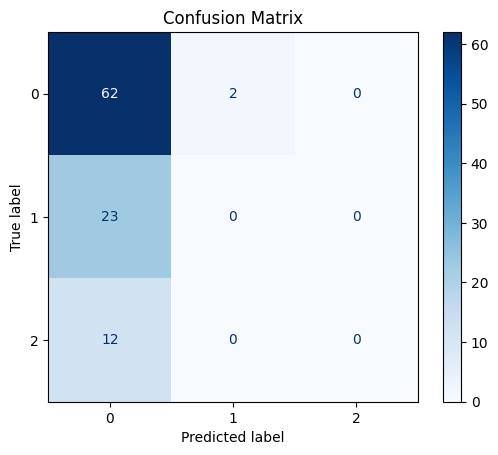

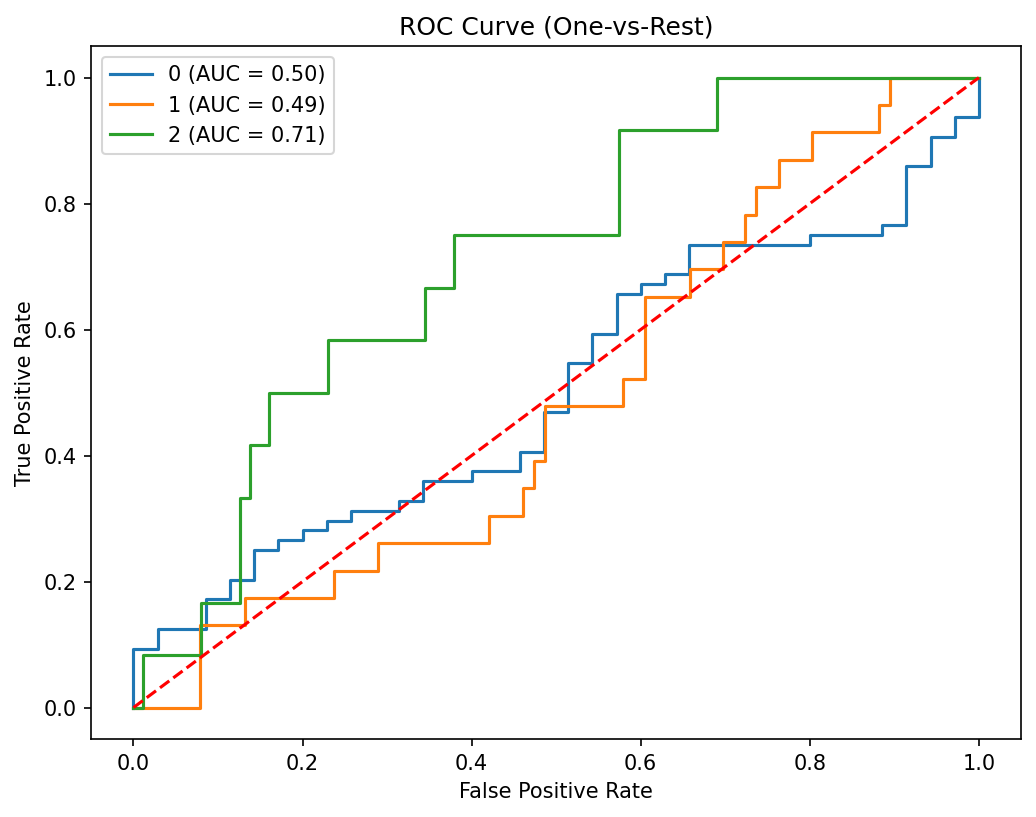

Training and evaluation complete


In [6]:
for problem_type in problem_types:
    for input_type in input_types:
        print(f"Training XGBoost for {problem_type} using {input_type} features...")
        results = run_xgboost(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
        
        # Evaluate the model
        print(f"Evaluating the model...")
        evaluate_model(final_model, X_test, y_test, problem_type, input_type, "XGBoost")
        
        print("Training and evaluation complete")


In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, roc_curve, auc
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import gaussian_kde


def get_file_paths(problem_type, input_type_pca, input_type_filter):
    """
    Generate file paths dynamically based on problem type and input type.
    """
    problem = "reg" if problem_type == "regression" else "class"
    base_dir_pca = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_pca}/pre_1_filter/{problem}/"
    base_dir_filter = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_filter}/"
    train_file = os.path.join(base_dir_pca, f"train_pca_reduced_{problem}.csv")
    test_file = 'PCA_pre_filtered/input/test_reduced_class_Potency.csv'
    #test_file = 'PCA_post_filtered/input/test_reduced_reg_wIC50.csv'
    return train_file, test_file


def load_data(problem_type, train_file, test_file, save_dir=None):
    """
    Load training and test datasets.
    """
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    label_encoder = None

    train_chembl_ids = train_data['Molecule ChEMBL ID']
    test_chembl_ids = test_data['Molecule ChEMBL ID']

    if problem_type == 'regression':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_train = train_data['-logIC50']
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_test = test_data['-logIC50']
    elif problem_type == 'classification':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_train = train_data['Potency'].str.split('\n').str[0].str.strip()
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_test = test_data['Potency'].str.split('\n').str[0].str.strip()

        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
        y_test = pd.Series(label_encoder.transform(y_test), index=y_test.index)

        # Print label mapping for classification
        print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

    # Ensure test data matches training feature columns
    train_features = X_train.columns
    for col in set(train_features) - set(X_test.columns):
        X_test[col] = 0
    X_test = X_test[train_features]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        train_data.to_csv(os.path.join(save_dir, 'modified_train.csv'), index=False)
        test_data.to_csv(os.path.join(save_dir, 'modified_test.csv'), index=False)

    return X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids



def cross_validation(problem_type, model, X_train, y_train, n_splits=5, output_dir=None, label_encoder=None):
    """
    Perform cross-validation with data distribution plots and hyperparameter tuning.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    tuned_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Plot data distribution for the current fold
        plt.figure(figsize=(12, 6))
        if problem_type == "regression":
            sns.histplot(y_train_fold, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
            sns.histplot(y_val_fold, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
            plt.xlabel("-log(IC50)")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Regression)")
        else:
            sns.countplot(
                x=label_encoder.inverse_transform(y_train_fold),
                label="Train",
                color="blue",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            sns.countplot(
                x=label_encoder.inverse_transform(y_val_fold),
                label="Validation",
                color="orange",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            plt.xlabel("Class")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Classification)")

        plt.legend(["Train", "Validation"])
        if output_dir:
            plt.savefig(os.path.join(output_dir, f"fold_{fold}_data_distribution.png"), dpi=150)
        plt.show()

        # Hyperparameter tuning with RandomizedSearchCV
        param_distributions = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_squared_error' if problem_type == "regression" else 'accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42,
        )
        random_search.fit(X_train_fold, y_train_fold)

        best_model = random_search.best_estimator_
        tuned_models.append(best_model)

        y_val_pred = best_model.predict(X_val_fold)
        if problem_type == "regression":
            metric = mean_squared_error(y_val_fold, y_val_pred)
        elif problem_type == "classification" and label_encoder is not None:
            metric = accuracy_score(y_val_fold, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    return tuned_models, np.mean(fold_metrics)




def evaluate_model(problem_type, model, X_test, y_test, output_dir, label_encoder=None, test_chembl_ids=None):
    """
    Evaluate the model and save predictions and plots.
    """
    y_pred = model.predict(X_test)
    if problem_type == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(os.path.join(output_dir, "regression_predictions.csv"), index=False)

        # Actual vs Predicted plot
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel("Actual IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Regression: Actual vs Predicted")
        plt.savefig(os.path.join(output_dir, "regression_actual_vs_predicted.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "regression",
            "input_type": "PCA",
            "MSE": mse,
            "R²": r2
        }])
        performance_summary.to_csv(os.path.join(output_dir, "regression_performance_summary.csv"), index=False)

        return {"MSE": mse, "R²": r2}

    elif problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)

        # Convert numeric predictions and true labels back to original class names
        true_classes = label_encoder.inverse_transform(y_test)
        predicted_classes = label_encoder.inverse_transform(y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True Class": true_classes,
            "Predicted Class": predicted_classes
        })
        predictions.to_csv(os.path.join(output_dir, "classification_predictions.csv"), index=False)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix (Test Set)")
        plt.savefig(os.path.join(output_dir, "classification_confusion_matrix.png"))
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(output_dir, "roc_curve.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "classification",
            "input_type": "PCA",
            "Accuracy": accuracy
        }])
        performance_summary.to_csv(os.path.join(output_dir, "classification_performance_summary.csv"), index=False)

        return {"Accuracy": accuracy}


def main(problem_type, input_type_pca, input_type_filter, output_dir, save_dir=None, model_type="xgboost"):
    """
    Main pipeline for modeling with cross-validation and plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_file, test_file = get_file_paths(problem_type, input_type_pca, input_type_filter)
    X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids = load_data(
        problem_type, train_file, test_file, save_dir
    )

    if model_type == "xgboost":
        model = XGBRegressor(random_state=42) if problem_type == 'regression' else XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    elif model_type == "random_forest":
        model = RandomForestRegressor(random_state=42) if problem_type == 'regression' else RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    tuned_models, avg_metric = cross_validation(
        problem_type=problem_type,
        model=model,
        X_train=X_train,
        y_train=y_train,
        n_splits=5,
        output_dir=output_dir,
        label_encoder=label_encoder if problem_type == "classification" else None
    )
    best_model = tuned_models[np.argmin(avg_metric)] if problem_type == 'regression' else tuned_models[np.argmax(avg_metric)]

    # Feature importance plot
    if hasattr(best_model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        plot_importance(best_model, max_num_features=20)
        plt.title("Feature Importance")
        plt.savefig(os.path.join(output_dir, "feature_importance.png"))
        plt.show()

    # Evaluate on test set
    test_metrics = evaluate_model(problem_type, best_model, X_test, y_test, output_dir, label_encoder, test_chembl_ids)
    print(f"Test Metrics: {test_metrics}")


# Example Usage
main(
    problem_type='classification',  # 'classification' or 'regression'
    input_type_pca='PCA',
    input_type_filter='1_filter',
    output_dir=f'PCA_pre_filtered/results/classification/',
    save_dir='PCA_pre_filtered/modified_datasets/',
    model_type="xgboost"  # "xgboost" or "random_forest"
)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/PCA/pre_1_filter/class/train_pca_reduced_class.csv'